#Install libraries

In [3]:
!pip3 install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [4]:
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install pylatexenc==2.10
!pip install qiskit-nature
!pip install pyscf
!pip install sparse opt_einsum
!pip install qiskit-nature-pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 57.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [qiskit]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 61.1 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pylatexenc' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pylatexenc'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7e2011851c4ad29fad92c0c285f70f7158c87815364b2

Using VQE to calculate $ΔE$ in this eqution SO₃ + nH₂O → H₂SO₄ clusters (n=1-3)
$$\Delta E = E_{product}-E_{reactant}$$

In [36]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

def run_vqe(atom_coords):
    driver = PySCFDriver(
        atom=atom_coords,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    es_problem = driver.run()

    mapper = JordanWignerMapper()
    ansatz = UCCSD(
        num_spatial_orbitals=es_problem.num_spatial_orbitals,
        num_particles=es_problem.num_particles,
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            num_spatial_orbitals=es_problem.num_spatial_orbitals,
            num_particles=es_problem.num_particles,
            qubit_mapper=mapper,
        ),
    )


    vqe_solver = VQE(Estimator(), ansatz, SLSQP(maxiter=10))
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    #print(es_problem.num_spatial_orbitals,es_problem.num_particles)
    solver = GroundStateEigensolver(mapper, vqe_solver)
    result = solver.solve(es_problem)

    return result.total_energies[0].real


In [6]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

def fast_vqe(atom_coords,num_electrons=4, num_orbitals=4):
    # 1. Define the molecule and driver
    driver = PySCFDriver(
        atom=atom_coords,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # 2. Run the driver to get the full electronic structure result
    driver_result = driver.run()

    # 3. Apply active space reduction
    transformer = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_spatial_orbitals=num_orbitals,
    )
    transformed_result = transformer.transform(driver_result)

    # 4. Build the ElectronicStructureProblem from the transformed result
    #problem = ElectronicStructureProblem()
    #problem.grouped_property = transformed_result

    # 5. Define mapper and ansatz
    mapper = JordanWignerMapper()
    num_qubits = transformed_result.num_spin_orbitals
    ansatz = TwoLocal(
        num_qubits,
        rotation_blocks='ry',
        entanglement_blocks='cz',
        entanglement='linear',
        reps=1,
        insert_barriers=False
    )

    # 6. Define the VQE algorithm
    vqe_solver = VQE(Estimator(), ansatz, COBYLA(maxiter=50))
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    # 7. Solve the ground state
    solver = GroundStateEigensolver(mapper, vqe_solver)
    result = solver.solve(transformed_result)

    return result.total_energies[0].real


In [7]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.problems import ElectronicStructureProblem

def solve(atom_coords):
  driver = PySCFDriver(
      atom=atom_coords,
      basis="sto3g",
      charge=-2,
      spin=0,
      unit=DistanceUnit.ANGSTROM,
  )
  es_problem = driver.run()

  hf_energy = es_problem.reference_energy
  return hf_energy

In [8]:
H2O = ["O 0.000000 0.000000 0.000000;H 0.758602 0.000000 0.504284;H -0.758602 0.000000 0.504284"]
SO3 = ["S 0.000000 0.000000 0.000000;O 1.430000 0.000000 0.000000;O -0.715000 1.238000 0.000000;O -0.715000 -1.238000 0.000000"]
H2SO4 = [" S 0.0000 0.0000 0.0000; O 1.4200 0.0000 0.0000; O -0.7100 1.2300 0.0000; O -0.7100 -1.2300 0.0000; O 0.0000 0.0000 1.4300; H 0.0000 0.0000 2.1000; H 1.2000 0.0000 1.9000 ",
         " S 0.0000 0.0000 0.0000; O 1.4200 0.0000 0.0000; O -0.7100 1.2300 0.0000; O -0.7100 -1.2300 0.0000; O 0.0000 0.0000 1.4300; H 0.0000 0.0000 2.1000; H 1.2000 0.0000 1.9000; O 2.2000 0.0000 0.0000; H 2.6000 0.4000 0.0000; H 2.6000 -0.4000 0.0000 ",
         " S 0.0000 0.0000 0.0000; O 1.4200 0.0000 0.0000; O -0.7100 1.2300 0.0000; O -0.7100 -1.2300 0.0000; O 0.0000 0.0000 1.4300; H 0.0000 0.0000 2.1000; H 1.2000 0.0000 1.9000; O 2.2000 0.0000 0.0000; H 2.6000 0.4000 0.0000; H 2.6000 -0.4000 0.0000; O -2.2000 0.0000 0.0000; H -2.6000 0.4000 0.0000; H -2.6000 -0.4000 0.0000 "]

In [9]:
from itertools import product
so3 = fast_vqe(SO3[0],10,6)
h2o = fast_vqe(H2O[0],8,6)
delta_E = {}
classic_d_E = {}
print("quantum","classic")
for n in range(3):
  reactant = so3+h2o*(n+1)
  product = fast_vqe(H2SO4[n],12,6)
  classic = solve(H2SO4[n])-(solve(SO3[0])+solve(H2O[0])*(n+1))
  print(n+1)
  print("reactant",reactant,solve(SO3[0])+solve(H2O[0])*(n+1))
  print("product",product,solve(H2SO4[n]))
  print("delta E",product-reactant,classic)
  delta_E[n+1]=product-reactant
  classic_d_E[n+1]=classic

/tmp/ipython-input-109814621.py:49: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, COBYLA(maxiter=50))


quantum classic
1
reactant -686.5587198996611 -686.6509662980037
product -687.318805681456 -687.77957556338
delta E -0.7600857817948281 -1.1286092653765536
2
reactant -759.6122939768959 -759.7628545044146
product -758.9579197193141 -759.2212298560287
delta E 0.6543742575818214 0.5416246483845271
3
reactant -832.6658680541307 -832.8747427108246
product -832.9409196352308 -832.8904952880648
delta E -0.2750515811001151 -0.015752577241869403


#Analyzes reaction rate and nucleation probability vs. relative humidity.
    
Parameters:

*   delta_E_kj: dict, keys are n (1 to 3), values are ΔE in kJ/mol
*   T: Temperature in Kelvin (default: 298.15 K)
*   $RH_{min}$: Minimum relative humidity in percent (default: 60)
*   $RH_{max}$: Maximum relative humidity in percent (default: 100)
$$k(T) = \dfrac{k_B T}{h} \exp\big(-\Delta G / (R T)\big)$$
$$
P\text{nucleation}(RH)
= \exp\Bigg[-\frac{\Delta G(RH)}{R T}\Bigg]
= \exp\Bigg[-\frac{\Delta G - n R T \ln(RH)}{R T}\Bigg]
= RH^n \cdot \exp\Bigg(-\frac{\Delta G}{R T}\Bigg)
$$

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_reaction(delta_E_kj, T=298.15, RH_min=60, RH_max=100):
    k_B = 1.380649e-23    # J/K
    h = 6.62607015e-34    # J*s
    R = 8.314462618       # J/(mol*K)
    P_sat = 3168          # Pa

    # Convert ΔE to J/mol
    delta_G = {n: e*1000 for n,e in delta_E_kj.items()}
    rh_range = np.linspace(RH_min/100, RH_max/100, 200)

    reaction_rates = {}
    nucleation_probs = {}

    for n, ΔG in delta_G.items():
        rates = []
        probs = []

        for rh in rh_range:
            if rh <= 0: rh = 1e-6
            P_H2O = rh * P_sat

            # 1) Reaction rate ~ nth-order in water
            k = (k_B*T/h) * np.exp(-ΔG/(R*T))
            rate = (P_H2O**n) * k
            rates.append(rate)

            # 2) Nucleation probability with RH effect (scaled for visibility)
            eff_G = ΔG - n*2500*np.log(rh)  # artificial scale factor for curvature
            prob = np.exp(-eff_G/(R*T))
            probs.append(prob)

        # Normalize rates for easier comparison
        rates = np.array(rates)
        rates /= rates.max()

        # Normalize probs to 0–1
        probs = np.array(probs)
        probs /= probs.max()

        reaction_rates[n] = rates
        nucleation_probs[n] = probs

    # === Plot Reaction Rate ===
    plt.figure(figsize=(10,5))
    for n in reaction_rates:
        plt.plot(rh_range*100, reaction_rates[n], label=f'n={n}')
    plt.title('Normalized Reaction Rate vs RH')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('Reaction Rate (normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # === Plot Nucleation Probability ===
    plt.figure(figsize=(10,5))
    for n in nucleation_probs:
        plt.plot(rh_range*100, nucleation_probs[n], label=f'n={n}')
    plt.title('Normalized Nucleation Probability vs RH')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('Nucleation Probability (normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()


#The quantum model resultes

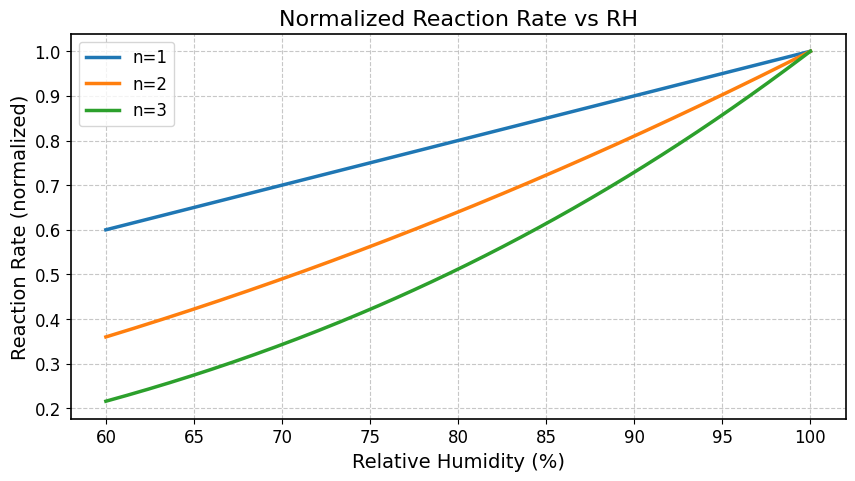

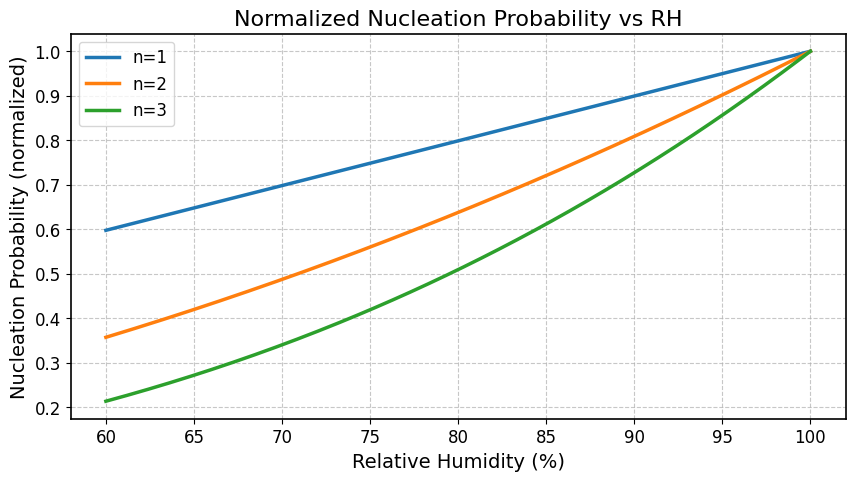

In [34]:
analyze_reaction(delta_E)

#The classical model resultes

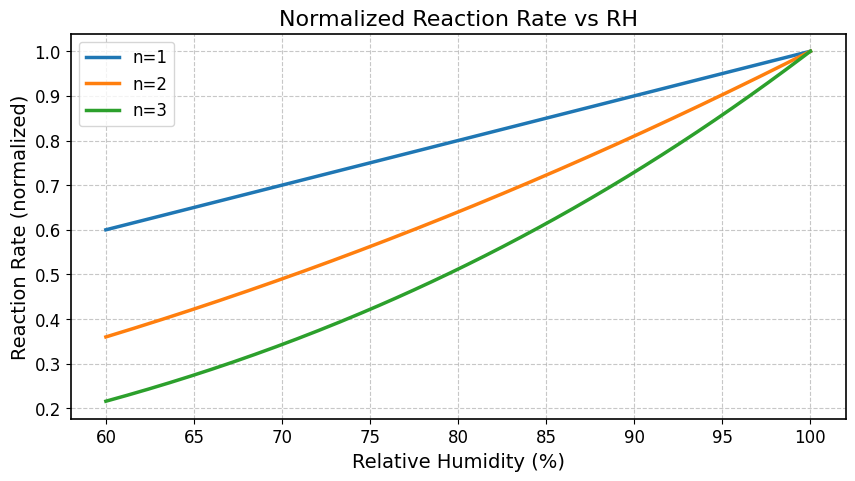

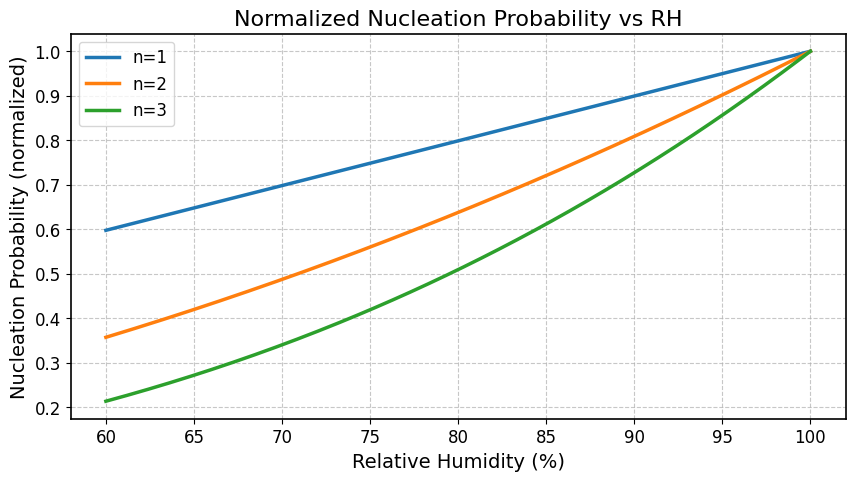

In [35]:
analyze_reaction(classic_d_E)